In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import pyabc

import healpy as hp
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
from abc_fake_data import model, distance
import generate_mocks as gm
import multipoles

#### the model

In [3]:
def model(parameters, selfunc, base_rate, dipdir, theta, phi, ell_max=8, poisson=True,
            excess_dipole_comps=None,
            return_alms=False):
    """
    Generates a healpix density map with dipole in fixed CMB dipole direction and excess angular power.
    Uses fiducial selection function (Quaia + galactic plane mask + smaller masks from S21).

    Parameters
    ----------
    parameters : dict
        keys:
            "dipole_amp" = dipole amplitude
            "log_excess" = log of the excess power (flat in Cell)
    selfunc : ndarray
        Selection function map. The map is generated with the same npix.
    base_rate : float
        Base rate (used to be a parameter, now hard-coded).
    excess_dipole_comps : array-like (len 3) or None, optional
        Optionally input a set of three orthogonal dipole amplitudes to specify the amplitude and direction of
        the "excess dipole." If `None`, uses `parameters['log_excess']` to draw random a1ms (like the other alms).
    return_alms : bool, optional (default True)
        Whether to return the alms drawn at random from the Cells.

    Returns
    -------
    Quasar number map.
    
    """

    nside = hp.npix2nside(len(selfunc))

    # expected dipole map
    amps = tools.spherical_to_cartesian(r=parameters["dipole_amp"],
                                        theta=np.pi/2-dipdir.icrs.dec.rad,
                                        phi=dipdir.icrs.ra.rad)
    expected_dipole_map = dipole.dipole(theta, phi, *amps)

    # excess power:
    excess_map = np.zeros_like(expected_dipole_map)
    if parameters["log_excess"] > -20:  # magic, kind of hacky but I want a way to have literally zero excess power
        if excess_dipole_comps is not None:
            assert len(excess_dipole_comps) == 3, "must input three dipole amplitudes (m=-1, 0, 1)"
            excess_map += dipole.dipole(theta, phi, *excess_dipole_comps)

            # then just add power in Cells starting at ell=2
            Cells = np.zeros(ell_max + 1)
            Cells[2:] += 10**parameters["log_excess"]
        else:
            # otherwise just add Cells like normal: flat, determined by input log_excess (and maybe input_a1ms)
            Cells = np.zeros(ell_max + 1)
            Cells[1:] += 10**parameters["log_excess"]   # because we don't want excess power in the monopole
        
        # generate excess power in the map by randomly drawing alms from the Cell spectrum
        if return_alms == True:
            excess_map_, alms = hp.sphtfunc.synfast(Cells, nside, alm=True)
            excess_map += excess_map_
        else:
            excess_map += hp.sphtfunc.synfast(Cells, nside)

    # smooth overdensity map
    smooth_overdensity_map = expected_dipole_map + excess_map

    # poisson sample, including the base rate and the selfunc map
    number_map = (1. + smooth_overdensity_map) * base_rate * selfunc
    if poisson == True:
        rng = np.random.default_rng(seed=None) # should I put a seed in here??
        number_map = rng.poisson(number_map)

    res = { "data" : number_map }

    if return_alms == True:
        res["alms"] = alms
    if excess_dipole_comps is not None:
        res["excess_dipole_comps"] = excess_dipole_comps

    return res

#### things for all results

In [4]:
# helper function to get case tag
def case_dir(dipamp, log_excess, base_rate, selfunc_str, tag=''):
    return os.path.join(resdir, f'dipole-{dipamp:.4f}_excess-1e{log_excess}_base-rate-{base_rate:.4f}_{selfunc_str}{tag}')

In [5]:
# result directory and nside at which we generate the maps
resdir = '/scratch/aew492/lss-dipoles_results/results/ABC/fake_data'
nside = 64

### fake Quaia data: kinematic dipole + excess dipole in kinematic dipole direction

In [21]:
input_dipamp = 0.0052
input_log_excess = -5.0
base_rate = 33.6330
selfunc_str = 'ones'  # meaning perfect completeness everywhere

nmocks = 500
ngens = 14

resdict = np.load(os.path.join(case_dir(input_dipamp, input_log_excess, base_rate, selfunc_str, tag='_parallel-excess-dipole'),
                               f'{nmocks}mocks_{ngens}gens_2025-03-17', 'results.npy'),
                  allow_pickle=True).item()
data = resdict['data']  # the data as raw quasar counts
selfunc = resdict['selfunc']
data_pars = resdict['data_pars']
observation = resdict['observation']  # the data as overdensity
history = resdict['history']  # History object
prior = resdict['prior']  # dictionary
posterior = resdict['posterior']  # pandas dataframe and weights associated with the final posterior
old_posteriors = resdict['old_posteriors']  # posteriors from the other generations

In [22]:
# what is the total dipole in the input data, i.e. kinematic dipole + excess dipole, projected along the kinematic dipole direction?
# cmb dipole direction
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
# kinematic dipole components
kinematic_comps = tools.spherical_to_cartesian(r=data_pars['dipole_amp'],
                                        theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                        phi=cmb_dipdir.icrs.ra.rad)
total_dipole_comps = kinematic_comps + data['excess_dipole_comps']
total_dipamp = np.linalg.norm(total_dipole_comps)
# what is the projection of the total dipole along the kinematic/CMB dipole direction?
total_dipamp_proj = np.dot(total_dipole_comps, kinematic_comps) / np.linalg.norm(kinematic_comps)

kinematic_dir = dipole.get_dipole(kinematic_comps)[1]
excess_dir = dipole.get_dipole(data['excess_dipole_comps'])[1]
total_dipdir = dipole.get_dipole(total_dipole_comps)[1]
print(f"kinematic dipole\t=\t{np.linalg.norm(kinematic_comps):.5f}\tttowards (l,b) = ({kinematic_dir.galactic.l:.2f}, {kinematic_dir.galactic.b:.2f})")
print(f"excess dipole\t\t=\t{np.linalg.norm(data['excess_dipole_comps']):.5f}\tttowards (l,b) = ({excess_dir.galactic.l:.2f}, {excess_dir.galactic.b:.2f})")
print(f"total dipole\t\t=\t{np.linalg.norm(total_dipole_comps):.5f}\tttowards (l,b) = ({total_dipdir.galactic.l:.2f}, {total_dipdir.galactic.b:.2f})")

kinematic dipole	=	0.00520	ttowards (l,b) = (264.00 deg, 48.00 deg)
excess dipole		=	0.00268	ttowards (l,b) = (264.00 deg, 48.00 deg)
total dipole		=	0.00788	ttowards (l,b) = (264.00 deg, 48.00 deg)


Text(0.5, 0.98, 'ABC posteriors, fake Quaia, nside=1')

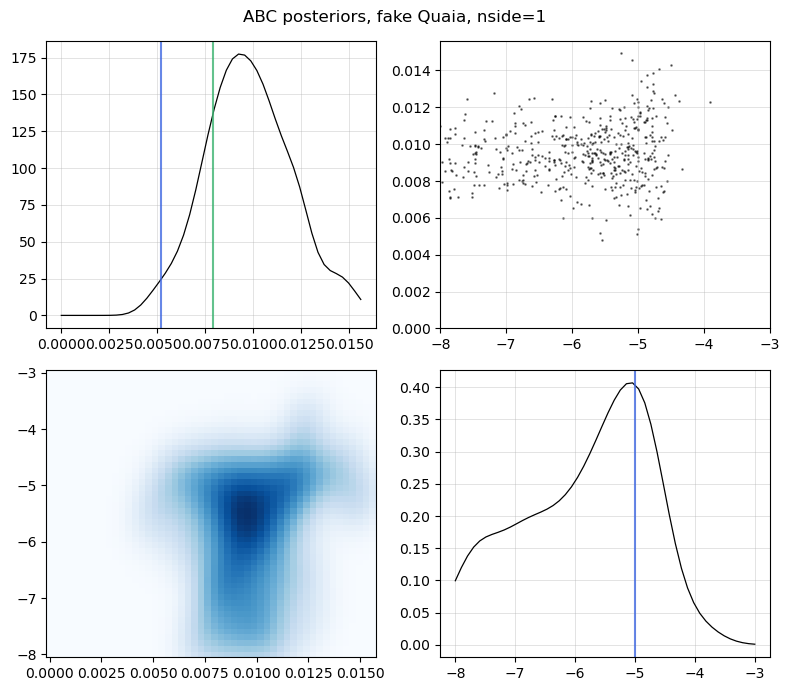

In [23]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(8,7), tight_layout=True)

for i, par_id in enumerate(par_ids):

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d(history, prior, par_id)
    ax.plot(x, pdf, c='k', alpha=1., lw=0.9)
    if par_id == 'dipole_amp':
        ax.axvline(input_dipamp, c='royalblue', alpha=0.8)
        ax.axvline(total_dipamp_proj, c='mediumseagreen', alpha=0.8)
    if par_id == 'log_excess':
        ax.axvline(input_log_excess, c='royalblue', alpha=0.8)
    ax.grid(alpha=0.5, lw=0.5)
    # ax.axvline(data_pars[par_id], c='royalblue', alpha=0.7)

    # axs[i,0].set_ylabel(par_id)
    # axs[len(par_ids)-1,i].set_xlabel(par_id)

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d(history, prior, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='Blues')

        # upper
        ax = axs[j, i]
        tools.scatter(history, prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
        ax.grid(alpha=0.5, lw=0.5)
    
fig.suptitle(f'ABC posteriors, fake Quaia, nside=1')

In [24]:
# median posteriors?
print(f"median posterior dipole amp (in CMB dipole direction) is {np.median(posterior[0]['dipole_amp']):.4f}")
print(f"median posterior log excess power is {np.median(posterior[0]['log_excess']):.4f}")

median posterior dipole amp (in CMB dipole direction) is 0.0095
median posterior log excess power is -5.6485


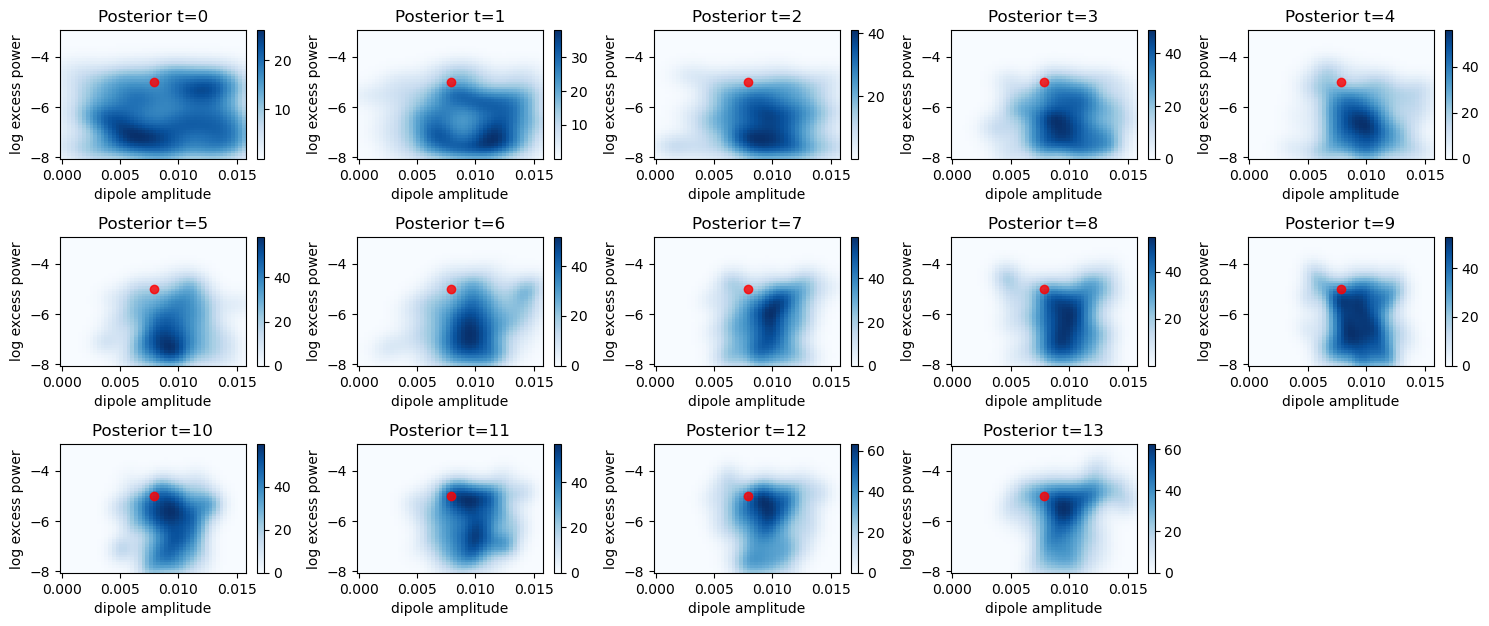

In [25]:
# evolution of the posterior
fig = plt.figure(figsize=(15, 8), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot((history.max_t + 1) // 3, 5, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=prior['dipole_amp'][0],
        xmax=prior['dipole_amp'][0] + prior['dipole_amp'][1],
        y="log_excess",
        yname=r"log excess power",
        ymin=prior['log_excess'][0],
        ymax=prior['log_excess'][0] + prior['log_excess'][1],
        ax=ax,
        cmap='Blues'
    )
    ax.plot(total_dipamp_proj, input_log_excess, marker='o', c='r', alpha=0.8)
    ax.set_title(f"Posterior t={t}")

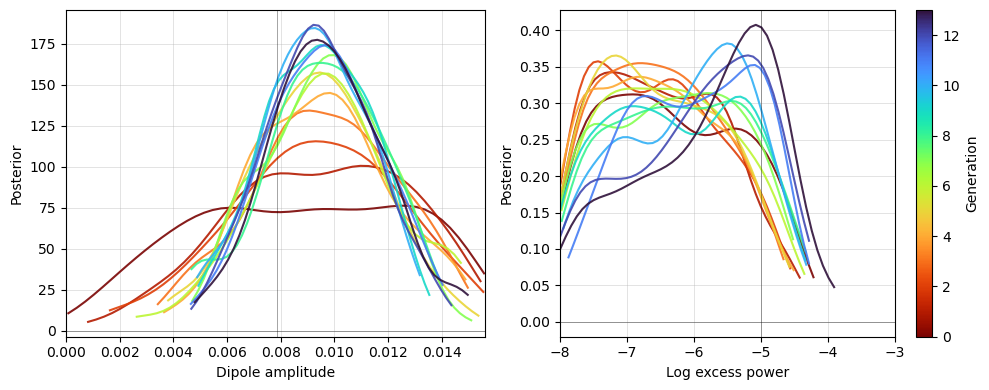

In [26]:
# and the 1D distributions
fig, axs = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)
norm = mpl.colors.Normalize(vmin=0, vmax=history.max_t)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo_r')

for i in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(history, "dipole_amp", t=i, ax=axs[0], color=smap.to_rgba(i), alpha=0.9)
    pyabc.visualization.plot_kde_1d_highlevel(history, "log_excess", t=i, ax=axs[1], color=smap.to_rgba(i), alpha=0.9)

axs[0].set_xlabel('Dipole amplitude')
axs[0].set_xlim(prior['dipole_amp'][0], sum(prior['dipole_amp']))
axs[0].axvline(total_dipamp_proj, c='k', alpha=0.5, lw=0.5)
axs[1].set_xlabel('Log excess power')
axs[1].set_xlim(prior['log_excess'][0], sum(prior['log_excess']))
axs[1].axvline(input_log_excess, c='k', alpha=0.5, lw=0.5)
for ax in axs:
    ax.grid(alpha=0.5, lw=0.5)
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=axs[1], label='Generation')

#### look at the maps

In [27]:
# get the excess (all multipoles and dipole only) maps from the stored alms
excess_map = hp.sphtfunc.alm2map(data['alms'], 64)
excess_dipmap = hp.sphtfunc.alm2map(data['alms'][:3], 64)

# and the input kinematic dipole
kinematic_dipmap = dipole.dipole_map([0., *kinematic_comps])

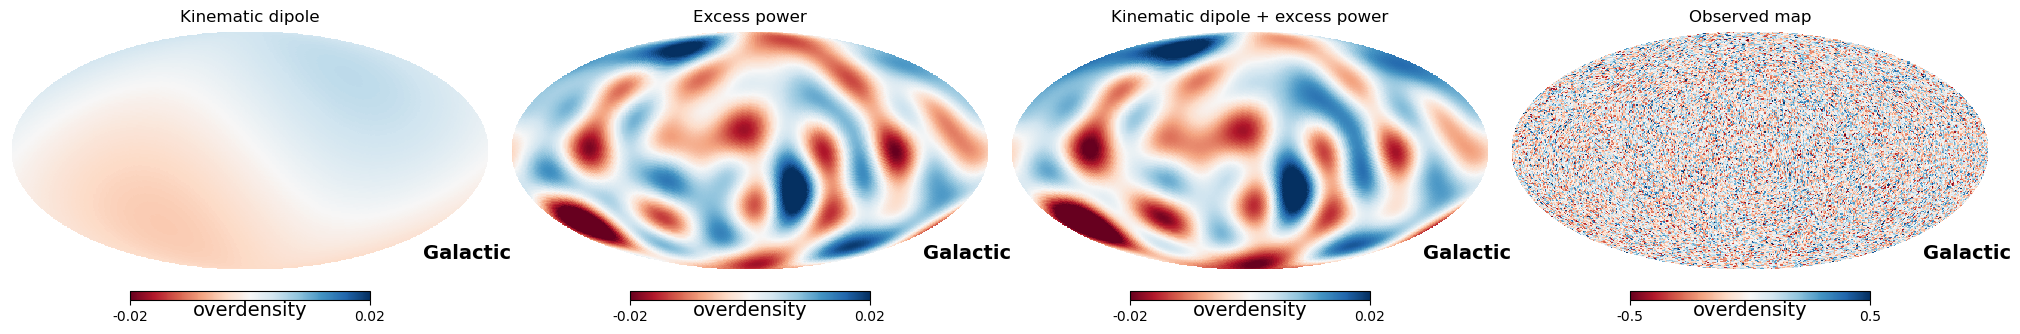

In [31]:
fig = plt.figure(figsize=(20,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', badcolor='w', unit='overdensity', fig=fig)
hp.mollview(kinematic_dipmap, min=-0.02, max=0.02, sub=(1,4,1), title='Kinematic dipole', **kwargs)
hp.mollview(excess_map, min=-0.02, max=0.02, sub=(1,4,2), title='Excess power', **kwargs)
hp.mollview(kinematic_dipmap + excess_map, min=-0.02, max=0.02, sub=(1,4,3), title='Kinematic dipole + excess power', **kwargs)
hp.mollview(observation, min=-0.5, max=0.5, sub=(1,4,4), title='Observed map', **kwargs)

In [32]:
#  posterior mocks
nmocks = 500
mean_mock = np.zeros_like(data['data']).astype(float)
for i in range(nmocks):
    mock = np.load(os.path.join(case_dir(input_dipamp, input_log_excess, base_rate, selfunc_str, tag='_no-SN_parallel-excess-dipole'),
                               f'{nmocks}mocks_{ngens}gens_2025-03-11/accepted_samples',
                                f'mock{i}.npy')).astype(float)
    mock[mock == 0.] = np.nan
    mean_mock += mock
mean_mock /= nmocks

mean_mock_corr = mean_mock / selfunc  # (correcting by selfunc does nothing in this case since it's just ones!)
data_corr = data['data'] / selfunc

# convert counts to overdensities
odmap_mean_mock_corr = mean_mock_corr / np.nanmean(mean_mock_corr) - 1
odmap_data_corr = data_corr / np.nanmean(data_corr) - 1

# in this case, since there aren't any selection effects, the overdensity map we just made should match the "observation" map in the resdict
assert np.allclose(odmap_data_corr, observation)

In [34]:
# since there is shot noise, smooth the observed map to compare to the mean posterior mock:
odmap_data_corr_smoothed = tools.smooth_map(odmap_data_corr, sr=1)

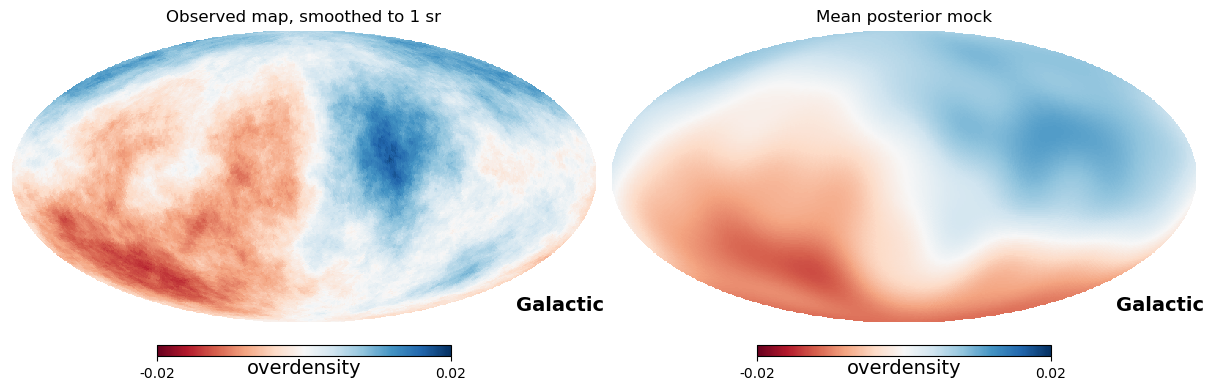

In [35]:
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', badcolor='w', unit='overdensity', fig=fig)
hp.mollview(odmap_data_corr_smoothed, min=-0.02, max=0.02, sub=(1,2,1), title='Observed map, smoothed to 1 sr', **kwargs)
hp.mollview(odmap_mean_mock_corr, min=-0.02, max=0.02, sub=(1,2,2), title='Mean posterior mock', **kwargs)

## "double dipole"

### fake Quaia data: kinematic dipole + excess dipole in kinematic dipole direction, _no_ noise, _no_ selection effects

In [47]:
input_dipamp = 0.0052
input_log_excess = -5.0
base_rate = 33.6330
selfunc_str = 'ones'  # meaning perfect completeness everywhere

nmocks = 500
ngens = 14

resdict = np.load(os.path.join(case_dir(input_dipamp, input_log_excess, base_rate, selfunc_str, tag='_no-SN_parallel-excess-dipole'),
                               f'{nmocks}mocks_{ngens}gens_2025-03-11', 'results.npy'),
                  allow_pickle=True).item()
data = resdict['data']  # the data as raw quasar counts
selfunc = resdict['selfunc']
data_pars = resdict['data_pars']
observation = resdict['observation']  # the data as overdensity
history = resdict['history']  # History object
prior = resdict['prior']  # dictionary
posterior = resdict['posterior']  # pandas dataframe and weights associated with the final posterior
old_posteriors = resdict['old_posteriors']  # posteriors from the other generations

In [70]:
# what is the total dipole in the input data, i.e. kinematic dipole + excess dipole, projected along the kinematic dipole direction?
# cmb dipole direction
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
# kinematic dipole components
kinematic_comps = tools.spherical_to_cartesian(r=data_pars['dipole_amp'],
                                        theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                        phi=cmb_dipdir.icrs.ra.rad)
total_dipole_comps = kinematic_comps + data['excess_dipole_comps']
total_dipdir = SkyCoord(*tools.thetaphi_to_lonlat(*tools.xyz_to_thetaphi(total_dipole_comps)))
total_dipamp = np.linalg.norm(total_dipole_comps)
# what is the projection of the total dipole along the kinematic/CMB dipole direction?
total_dipamp_proj = np.dot(total_dipole_comps, kinematic_comps) / np.linalg.norm(kinematic_comps)

Text(0.5, 0.98, 'ABC posteriors, fake Quaia, nside=1')

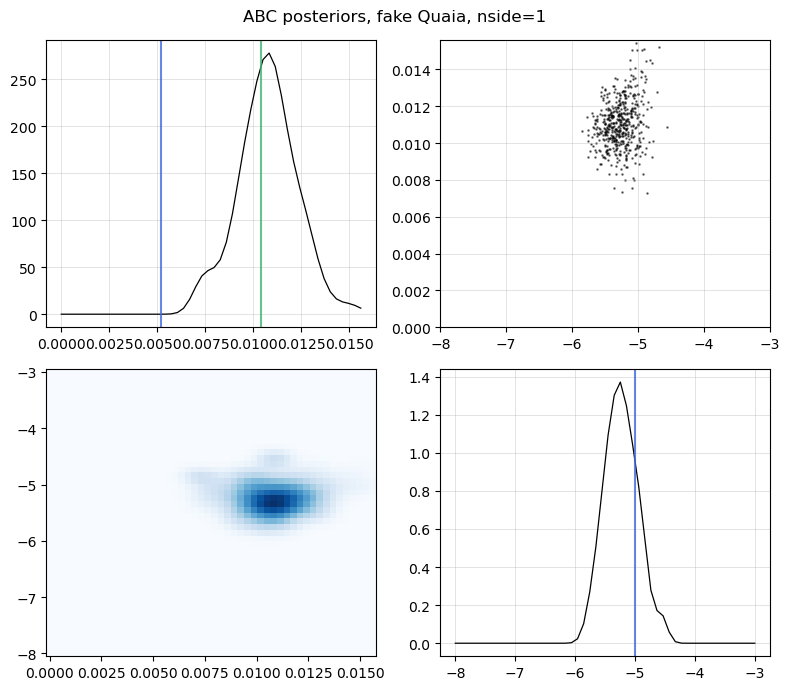

In [71]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(8,7), tight_layout=True)

for i, par_id in enumerate(par_ids):

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d(history, prior, par_id)
    ax.plot(x, pdf, c='k', alpha=1., lw=0.9)
    if par_id == 'dipole_amp':
        ax.axvline(input_dipamp, c='royalblue', alpha=0.8)
        ax.axvline(total_dipole_proj, c='mediumseagreen', alpha=0.8)
    if par_id == 'log_excess':
        ax.axvline(input_log_excess, c='royalblue', alpha=0.8)
    ax.grid(alpha=0.5, lw=0.5)
    # ax.axvline(data_pars[par_id], c='royalblue', alpha=0.7)

    # axs[i,0].set_ylabel(par_id)
    # axs[len(par_ids)-1,i].set_xlabel(par_id)

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d(history, prior, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='Blues')

        # upper
        ax = axs[j, i]
        tools.scatter(history, prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
        ax.grid(alpha=0.5, lw=0.5)
    
fig.suptitle(f'ABC posteriors, fake Quaia, nside=1')

In [78]:
# median posteriors?
print(f"median posterior dipole amp (in CMB dipole direction) is {np.median(posterior[0]['dipole_amp']):.4f}")
print(f"median posterior log excess power is {np.median(posterior[0]['log_excess']):.4f}")

median posterior dipole amp (in CMB dipole direction) is 0.0110
median posterior log excess power is -5.2780


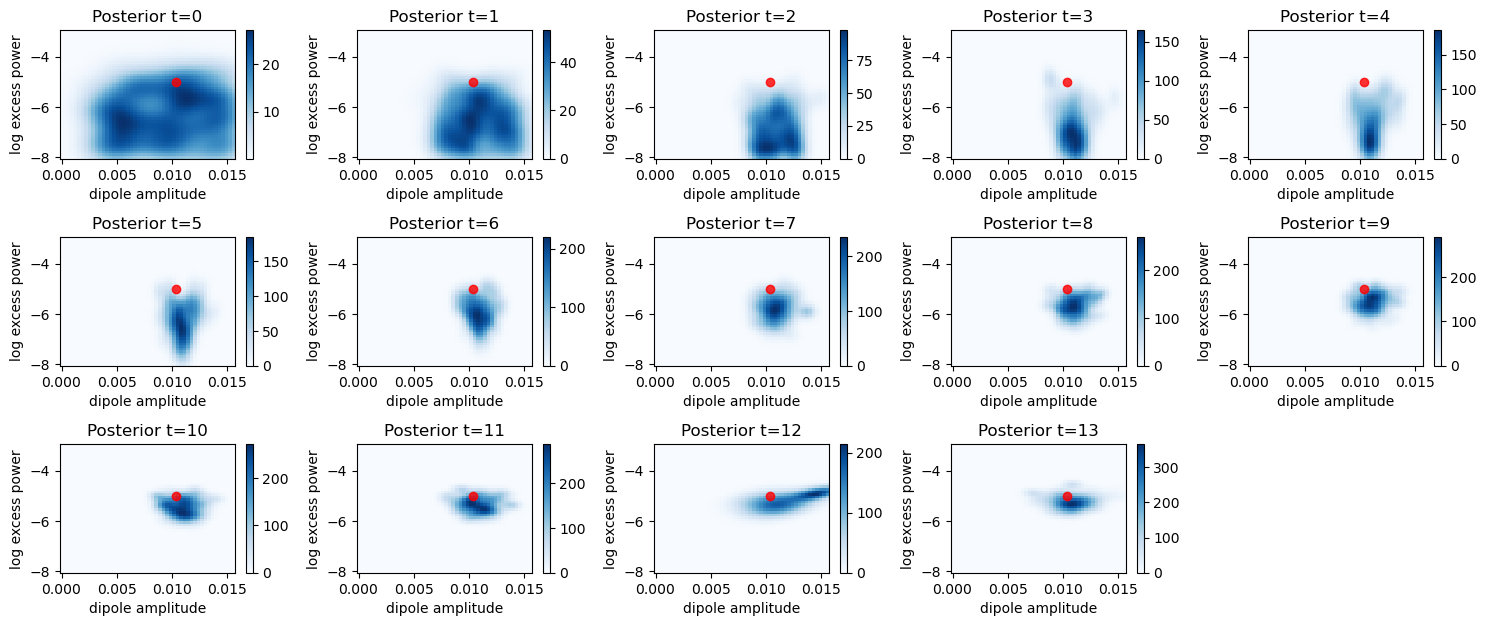

In [79]:
# evolution of the posterior
fig = plt.figure(figsize=(15, 8), tight_layout=True)
for t in range(history.max_t + 1):
    ax = fig.add_subplot((history.max_t + 1) // 3, 5, t + 1)
    df, w = history.get_distribution(t=t)
    ax = pyabc.visualization.plot_kde_2d(
        df,
        w,
        x="dipole_amp",
        xname=r"dipole amplitude",
        xmin=prior['dipole_amp'][0],
        xmax=prior['dipole_amp'][0] + prior['dipole_amp'][1],
        y="log_excess",
        yname=r"log excess power",
        ymin=prior['log_excess'][0],
        ymax=prior['log_excess'][0] + prior['log_excess'][1],
        ax=ax,
        cmap='Blues'
    )
    ax.plot(total_dipole_proj, input_log_excess, marker='o', c='r', alpha=0.8)
    ax.set_title(f"Posterior t={t}")

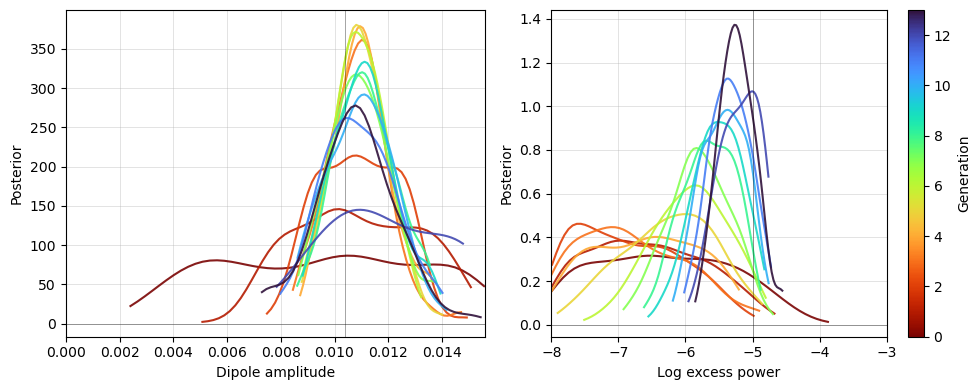

In [80]:
# and the 1D distributions
fig, axs = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)
norm = mpl.colors.Normalize(vmin=0, vmax=history.max_t)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo_r')

for i in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(history, "dipole_amp", t=i, ax=axs[0], color=smap.to_rgba(i), alpha=0.9)
    pyabc.visualization.plot_kde_1d_highlevel(history, "log_excess", t=i, ax=axs[1], color=smap.to_rgba(i), alpha=0.9)

axs[0].set_xlabel('Dipole amplitude')
axs[0].set_xlim(prior['dipole_amp'][0], sum(prior['dipole_amp']))
axs[0].axvline(total_dipole_proj, c='k', alpha=0.5, lw=0.5)
axs[1].set_xlabel('Log excess power')
axs[1].set_xlim(prior['log_excess'][0], sum(prior['log_excess']))
axs[1].axvline(input_log_excess, c='k', alpha=0.5, lw=0.5)
for ax in axs:
    ax.grid(alpha=0.5, lw=0.5)
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=axs[1], label='Generation')

#### look at the maps

In [81]:
# get the excess (all multipoles and dipole only) maps from the stored alms
excess_map = hp.sphtfunc.alm2map(data['alms'], 64)
excess_dipmap = hp.sphtfunc.alm2map(data['alms'][:3], 64)

# and the input kinematic dipole
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
kinematic_comps = tools.spherical_to_cartesian(r=input_dipamp,
                                    theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                    phi=cmb_dipdir.icrs.ra.rad)
kinematic_dipmap = dipole.dipole_map([0., *kinematic_comps])

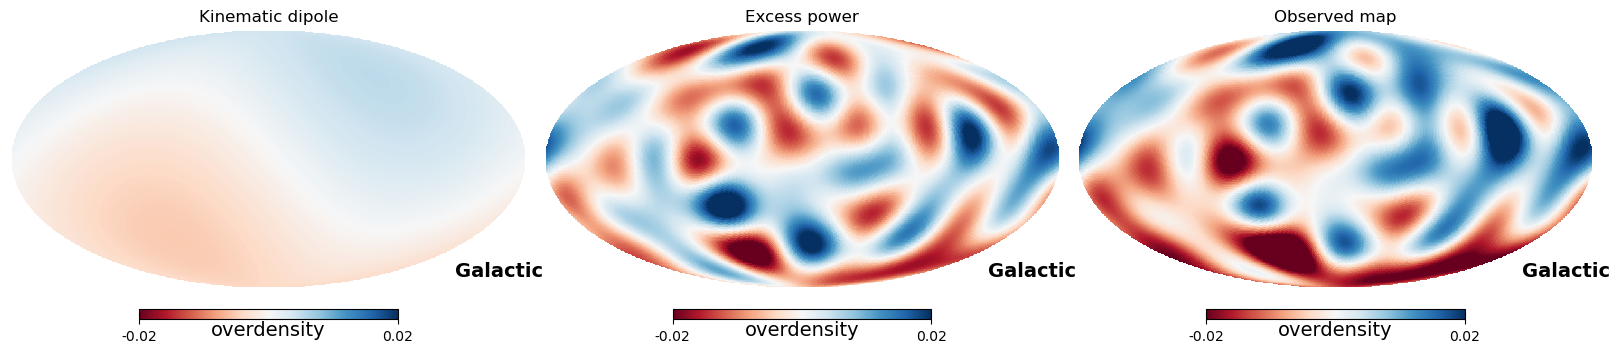

In [82]:
fig = plt.figure(figsize=(16,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', badcolor='w', unit='overdensity', fig=fig)
hp.mollview(kinematic_dipmap, min=-0.02, max=0.02, sub=(1,3,1), title='Kinematic dipole', **kwargs)
hp.mollview(excess_map, min=-0.02, max=0.02, sub=(1,3,2), title='Excess power', **kwargs)
hp.mollview(observation, min=-0.02, max=0.02, sub=(1,3,3), title='Observed map', **kwargs)

In [84]:
#  posterior mocks
nmocks = 500
mean_mock = np.zeros_like(data['data']).astype(float)
for i in range(nmocks):
    mock = np.load(os.path.join(case_dir(input_dipamp, input_log_excess, base_rate, selfunc_str, tag='_no-SN_parallel-excess-dipole'),
                               f'{nmocks}mocks_{ngens}gens_2025-03-11/accepted_samples',
                                f'mock{i}.npy')).astype(float)
    mock[mock == 0.] = np.nan
    mean_mock += mock
mean_mock /= nmocks

mean_mock_corr = mean_mock / selfunc  # (correcting by selfunc does nothing in this case since it's just ones!)
data_corr = data['data'] / selfunc

In [85]:
# convert counts to overdensities
odmap_mean_mock_corr = mean_mock_corr / np.nanmean(mean_mock_corr) - 1
odmap_data_corr = data_corr / np.nanmean(data_corr) - 1

In [86]:
# in this case, since there aren't any selection effects, the overdensity map we just made should match the "observation" map in the resdict
assert np.allclose(odmap_data_corr, observation)

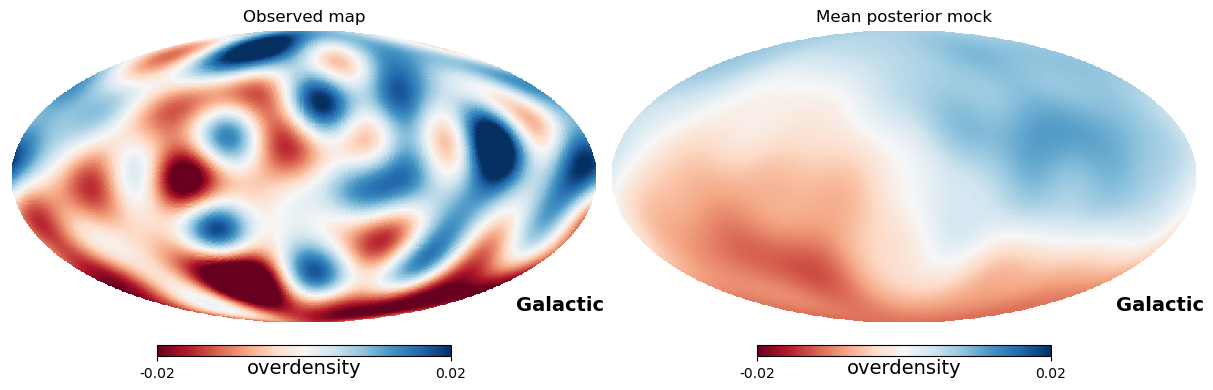

In [87]:
fig = plt.figure(figsize=(12,4))
kwargs = dict(coord=['C','G'], cmap='RdBu', badcolor='w', unit='overdensity', fig=fig)
hp.mollview(observation, min=-0.02, max=0.02, sub=(1,2,1), title='Observed map', **kwargs)
hp.mollview(odmap_mean_mock_corr, min=-0.02, max=0.02, sub=(1,2,2), title='Mean posterior mock', **kwargs)

In [88]:
# and what's the dipole in the mean posterior mock?
bestfit_dipamp, bestfit_dipdir = dipole.get_dipole(hp.fit_dipole(odmap_mean_mock_corr)[1])
print(f"dipole in mean posterior mock is {bestfit_dipamp:.4f} towards (l,b) = ({bestfit_dipdir.galactic.l:.2f}, {bestfit_dipdir.galactic.b:.2f})")

dipole in mean posterior mock is 0.0110 towards (l,b) = (268.00 deg, 47.51 deg)


In [89]:
print(f"total dipole in observed map is {total_dipole_proj:.4f} towards (l,b) = ({cmb_dipdir.galactic.l:.0f}, {cmb_dipdir.galactic.b:.0f})")
print(f"kinematic dipole in observed map is {input_dipamp:.4f} towards (l,b) = ({cmb_dipdir.galactic.l:.0f}, {cmb_dipdir.galactic.b:.0f})")

total dipole in observed map is 0.0104 towards (l,b) = (264 deg, 48 deg)
kinematic dipole in observed map is 0.0052 towards (l,b) = (264 deg, 48 deg)


### fake Quaia data: kinematic dipole + excess dipole in kinematic dipole direction

In [6]:
# load the results
resdir = '/scratch/aew492/lss-dipoles_results/results/ABC/fake_data'
nside = 64

input_dipamp = 0.0052
input_log_excess = -7.0
base_rate = 33.6330
selfunc_str = 'quaia_G20.0_orig'  # quaia selfunc

nmocks = 500
ngens = 15

resdict = np.load(os.path.join(case_dir(input_dipamp, input_log_excess, base_rate, selfunc_str, tag='_parallel-excess-dipole'),
                               f'{nmocks}mocks_{ngens}gens_2025-03-10', 'results.npy'),
                  allow_pickle=True).item()
data = resdict['data']  # the data as raw quasar counts
selfunc = resdict['selfunc']
data_pars = resdict['data_pars']
observation = resdict['observation']  # the data as overdensity
history = resdict['history']  # History object
prior = resdict['prior']  # dictionary
posterior = resdict['posterior']  # pandas dataframe and weights associated with the final posterior
old_posteriors = resdict['old_posteriors']  # posteriors from the other generations

In [7]:
# what is the total dipole in the input data, i.e. kinematic dipole + excess dipole, projected along the kinematic dipole direction?
# cmb dipole direction
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
# kinematic dipole components
kinematic_comps = tools.spherical_to_cartesian(r=data_pars['dipole_amp'],
                                        theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                        phi=cmb_dipdir.icrs.ra.rad)
total_dipole_comps = kinematic_comps + data['excess_dipole_comps']
# what is the projection of the total dipole along the kinematic/CMB dipole direction?
total_dipole_proj = np.dot(total_dipole_comps, kinematic_comps) / np.linalg.norm(kinematic_comps)

Text(0.5, 0.98, 'ABC posteriors, fake Quaia, nside=1')

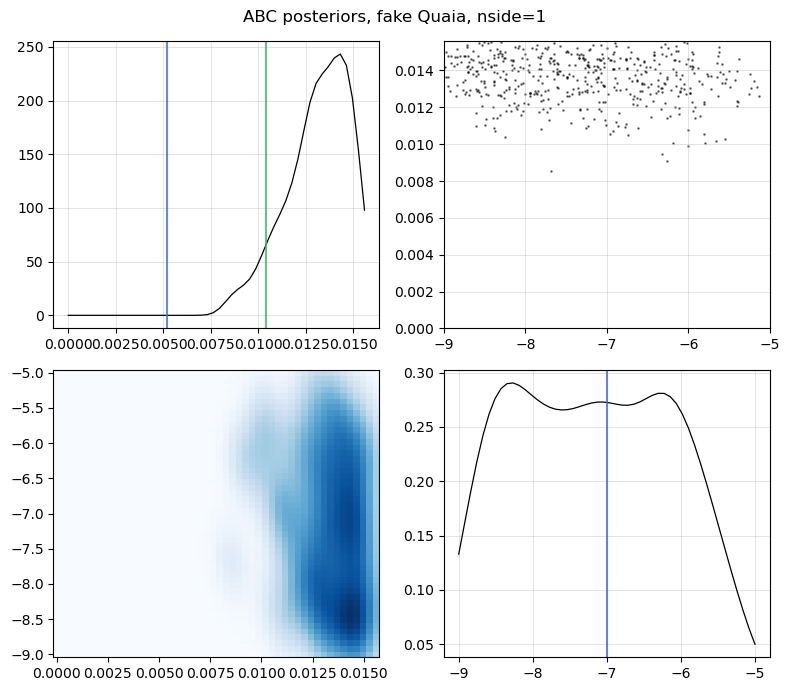

In [8]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(8,7), tight_layout=True)

for i, par_id in enumerate(par_ids):

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d(history, prior, par_id)
    ax.plot(x, pdf, c='k', alpha=1., lw=0.9)
    if par_id == 'dipole_amp':
        ax.axvline(input_dipamp, c='royalblue', alpha=0.8)
        ax.axvline(total_dipole_proj, c='mediumseagreen', alpha=0.8)
    if par_id == 'log_excess':
        ax.axvline(input_log_excess, c='royalblue', alpha=0.8)
    ax.grid(alpha=0.5, lw=0.5)
    # ax.axvline(data_pars[par_id], c='royalblue', alpha=0.7)

    # axs[i,0].set_ylabel(par_id)
    # axs[len(par_ids)-1,i].set_xlabel(par_id)

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d(history, prior, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='Blues')

        # upper
        ax = axs[j, i]
        tools.scatter(history, prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
        ax.grid(alpha=0.5, lw=0.5)
    
fig.suptitle(f'ABC posteriors, fake Quaia, nside=1')

#### look at the maps

In [ ]:
# because I saved the data pars and alms, we can reconstruct the input data without the selection effects and noise:


In [ ]:


# the input data
fig = plt.figure(figsize=(12,4))
hp.mollview(data['data'], coord=['C','G'], fig=fig, sub=(1,2,1))